In [ ]:
# !pip install pyspark

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, when, count, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt

In [2]:
# Install ngrok for port forwarding
!pip install pyngrok

In [3]:
from pyngrok import ngrok

ngrok.set_auth_token("2ofZ4IqA98neEwce2UIYcIhHDHk_6nJj5W9ad9uj6uwuWsUdF")

public_url = ngrok.connect(4050)
print("Spark UI is available at:", public_url)

Spark UI is available at: NgrokTunnel: "https://3c09-35-204-72-76.ngrok-free.app" -> "http://localhost:4050"


In [4]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("HotelBookingCancellation") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

sc = spark.sparkContext

# Load dataset
file_path = "hotel_bookings.csv"
sc.setJobGroup("Task1", "Reading CSV File")
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Distributed Data Cleaning/Processing


In [5]:
data.printSchema()
data.describe().show()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

Replacing null country values with the most frequent value.

Filling null values with '0' for 'children' column, as most of the bookings are with '0' number of children. And filling the remaining null values with '0' as we have a very few of them as null.

In [6]:
# Handling Missing Values
sc.setJobGroup("Task2", "Filling Missing Values")
mode_country = data.groupBy("country").count().orderBy("count", ascending=False).first()[0]
data = data.fillna({"country": mode_country})
data = data.fillna({"children": 0, "agent": 0, "company": 0})
data = data.fillna(0)
data = data.fillna(0)

Dropping irrelevant columns.

Most of the rows for this attribute are NULL, so dropping it.

In [7]:
# Drop the 'company' column
sc.setJobGroup("Task3", "Drop Company")
data = data.drop("company")

In [8]:
# Display the shape of the DataFrame
print(f"Data shape: {data.count()} rows and {len(data.columns)} columns")

Data shape: 119390 rows and 31 columns


deleting duplicate rows

In [9]:
# Remove duplicate rows
sc.setJobGroup("Task4", "Removing Duplicates")

data = data.dropDuplicates()

In [ ]:
# # Counting missing values to verify
# print("Missing values after filling:")
# data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

Changing the data type from float to int for below columns. As,

'children' column provides number of children per booking.
'agent' refers to the agent ID of the travel agency that made the booking.

In [10]:
from pyspark.sql.types import IntegerType

# Change data type of 'children' and 'agent' to integer
sc.setJobGroup("Task5", "Changing Data Types")

data = data.withColumn("children", col("children").cast(IntegerType()))
data = data.withColumn("agent", col("agent").cast(IntegerType()))

# Display data types of all columns
print("Updated data types:")
data.printSchema()

Updated data types:
root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = false)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_roo

In [11]:
# Display descriptive statistics for the 'adr' column
print("Descriptive statistics for 'adr':")
data.select("adr").describe().show()

Descriptive statistics for 'adr':
+-------+------------------+
|summary|               adr|
+-------+------------------+
|  count|             87389|
|   mean|106.33907002025309|
| stddev|55.013097108931404|
|    min|             -6.38|
|    max|            5400.0|
+-------+------------------+



**Dropping Outlier rows:**

adr: (Average Daily Rate) reflects the average daily price a guest pays for a room. In this dataset, there's a minimum value of -6.38, which isn’t realistic and likely indicates an error. Additionally, there's an unusually high value of 5400, which stands out as an outlier when compared to the rest of the data. Therefore, we'll remove these rows to ensure more accurate analysis.

Children and babies: The maximum values for both categories, ranging from 9 to 10, seem unusually high for a single reservation, indicating potential outliers. Also, any booking showing babies but no adults isn't logical and likely represents an error.

**Removing Inconsistent Rows:**

When the number of adults, babies, and children is zero, it suggests that there are no guests associated with the booking, which is invalid. So, dropping those rows from the data.

In [12]:
# Filter out outliers in the 'adr' column
sc.setJobGroup("Task6", "Filter out Outliers")

data = data.filter((col("adr") >= 0) & (col("adr") <= 1000))

# Display the new shape of the DataFrame
print(f"Data shape after filtering: {data.count()} rows and {len(data.columns)} columns")

# Filter rows based on conditions and drop them
filter1 = ((col("children") == 10) |
           (col("babies").isin([9, 10])) |
           ((col("adults") == 0) & (col("babies") > 0)))

data = data.filter(~filter1)

# Create the guest filter: rows where children, adults, and babies are all 0
guest_filter = ((col("children") == 0) &
                (col("adults") == 0) &
                (col("babies") == 0))

data = data.filter(~guest_filter)

Data shape after filtering: 87387 rows and 31 columns


Setting proper precesion for 'adr'

In [13]:
from pyspark.sql.functions import col, lit, when, round as spark_round, udf
from pyspark.sql.types import IntegerType

# Round the 'adr' column to 2 decimal places
sc.setJobGroup("Task7", "Rounding to 2 Decimals")

data = data.withColumn("adr", spark_round(col("adr"), 2))

Creating a new attribute to store the number of the month to utilize it furture for analysis.

In [14]:

sc.setJobGroup("Task8", "Label Encoding and Creating new column")

# Label encoding for the ordinal variable: 'arrival_date_month'
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Create a UDF to map month names to numbers
month_to_number = udf(lambda x: months.index(x) + 1 if x in months else None, IntegerType())

# Apply the UDF to create a new column
data = data.withColumn("arrival_date_month_number", month_to_number(col("arrival_date_month")))


In [15]:
sc.setJobGroup("Task9", "Printing Data Type for new column")

column_name = "arrival_date_month_number"
column_dtype = [field.dataType for field in data.schema.fields if field.name == column_name][0]
print(f"The data type of '{column_name}' is {column_dtype}")


The data type of 'arrival_date_month_number' is IntegerType()


# Checking for data imbalance

<ipython-input-16-4f8301bfad46>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="is_canceled", y="percentage", data=class_percentages_pd, palette=['darkturquoise', 'royalblue'])


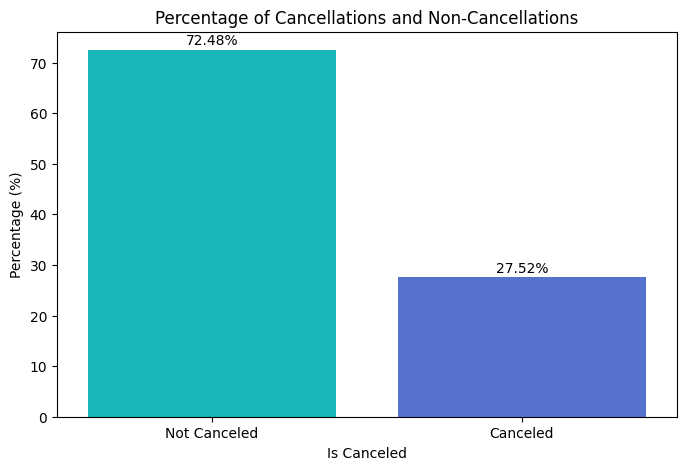

In [16]:
from pyspark.sql.functions import count, lit
import matplotlib.pyplot as plt
import seaborn as sns

sc.setJobGroup("Task10", "Imbalance Check")

# Calculate the percentage of each class
class_counts = data.groupBy("is_canceled").count()
total_count = data.count()
class_percentages = class_counts.withColumn("percentage", (col("count") / total_count) * 100).orderBy("is_canceled")

# Convert to Pandas for plotting
class_percentages_pd = class_percentages.toPandas()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="is_canceled", y="percentage", data=class_percentages_pd, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0, 80, 10))

for i, p in enumerate(class_percentages_pd["percentage"]):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()


The bar plot shows the proportion of canceled and non-canceled bookings in the dataset. About 37.08% of the bookings were canceled, while 62.92% were not. This suggests some imbalance in the target variable, but it's not extreme. Generally, a dataset is considered highly imbalanced when one category makes up 80-90% of the data. In this case, the canceled bookings (the smaller group) are still fairly well-represented, so we may not need to use resampling techniques like oversampling or undersampling to balance the classes.

Creating a new attribute 'arrival_date' for further analysis and Updating the data type

In [17]:
from pyspark.sql.functions import concat_ws, to_date

sc.setJobGroup("Task11", "Date Manipulation")

# Combine year, month, and day into a single string and convert to a date
data = data.withColumn("arrival_date", to_date(concat_ws("-", col("arrival_date_year"), col("arrival_date_month_number"), col("arrival_date_day_of_month"))))

# Convert 'reservation_status_date' to a date
data = data.withColumn("reservation_status_date", to_date(col("reservation_status_date")))


Removing Outliers in lead_time Using IQR(inter quartile range)

In [18]:
from pyspark.sql.functions import expr

sc.setJobGroup("Task12", "IQR")

# Calculate IQR and bounds
Q1 = data.approxQuantile("lead_time", [0.25], 0.01)[0]
Q3 = data.approxQuantile("lead_time", [0.75], 0.01)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows within bounds
data = data.filter((col("lead_time") >= lower_bound) & (col("lead_time") <= upper_bound))

# Display new shape
print(f"Data shape after outlier removal: {data.count()} rows and {len(data.columns)} columns")


Data shape after outlier removal: 84511 rows and 33 columns


# Feature Engineering

In [19]:
from pyspark.ml.feature import Bucketizer

sc.setJobGroup("Task13", "Feature Engineering")

# Create 'total_stay' feature
data = data.withColumn("total_stay", col("stays_in_weekend_nights") + col("stays_in_week_nights"))

# Create 'has_children' feature
data = data.withColumn("has_children", when((col("children") > 0) | (col("babies") > 0), lit(1)).otherwise(lit(0)))

# Create 'long_wait' feature
data = data.withColumn("long_wait", when(col("days_in_waiting_list") > 0, lit(1)).otherwise(lit(0)))

# Define bins and labels
bins = [float('-inf'), 30, 90, 180, float('inf')]
bucketizer = Bucketizer(splits=bins, inputCol="lead_time", outputCol="lead_time_category")

# Apply binning
data = bucketizer.setHandleInvalid("skip").transform(data)

# Map bucket indices to labels
lead_time_labels = {0: "Very Short", 1: "Short", 2: "Medium", 3: "Long"}
data = data.withColumn("lead_time_category", col("lead_time_category").cast("int").alias("category"))



**Log tranformation**

In [20]:
from pyspark.sql.functions import log1p

sc.setJobGroup("Task14", "Log Transformation")

# Apply log transformation
data = data.withColumn("adr", log1p(col("adr")))
data = data.withColumn("lead_time", log1p(col("lead_time")))


In [ ]:
# data.show(5)

# Machine Learning Algorithms

In [21]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
# Initialize Spark session
# spark = SparkSession.builder.appName("MLlibModeling").getOrCreate()

In [22]:
sc.setJobGroup("Task15", "Dropping Irrelevant Attributes")

# Drop irrelevant columns
columns_to_drop = ['arrival_date_month', 'country', 'agent', 'arrival_date_year',
                   'arrival_year_month', 'reservation_status', 'assigned_room_type',
                   'reservation_status_date', 'arrival_date']
data = data.drop(*columns_to_drop)

In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

sc.setJobGroup("Task16", "Categorical Encoding")

# Identify categorical columns
categorical_cols = ["reserved_room_type", "deposit_type"]

# Apply StringIndexer to convert categorical columns to numeric indices
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    data = indexer.fit(data).transform(data)

# Update feature columns to include the indexed categorical columns
feature_cols = [col for col in data.columns if col not in ["is_canceled", "hotel", "meal",
                                                           "market_segment", "distribution_channel",
                                                           "customer_type", "reserved_room_type",
                                                           "deposit_type"]]
feature_cols += [f"{col}_index" for col in categorical_cols]

# Apply VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

print("VectorAssembler successfully applied.")


VectorAssembler successfully applied.


In [24]:
sc.setJobGroup("Task17", "Data Splitting: Train and Test")

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

**Logistic Regression**

In [25]:
sc.setJobGroup("Task18", "Logistic Regression")

log_reg = LogisticRegression(featuresCol="features", labelCol="is_canceled", maxIter=1000)
log_reg_model = log_reg.fit(train_data)
log_reg_predictions = log_reg_model.transform(test_data)


In [26]:
sc.setJobGroup("Task19", "Decision Tree")

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="is_canceled")
dt_model = decision_tree.fit(train_data)
dt_predictions = dt_model.transform(test_data)


In [27]:
sc.setJobGroup("Task20", "Random Forest")

random_forest = RandomForestClassifier(featuresCol="features", labelCol="is_canceled", numTrees=50)
rf_model = random_forest.fit(train_data)
rf_predictions = rf_model.transform(test_data)


In [28]:
sc.setJobGroup("Task21", "GBTClassifier")

gbt = GBTClassifier(featuresCol="features", labelCol="is_canceled", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)


In [29]:
sc.setJobGroup("Task22", "Naive Bayes")

naive_bayes = NaiveBayes(featuresCol="features", labelCol="is_canceled")
nb_model = naive_bayes.fit(train_data)
nb_predictions = nb_model.transform(test_data)


In [30]:
sc.setJobGroup("Task23", "Linear SVC")

svm = LinearSVC(featuresCol="features", labelCol="is_canceled", maxIter=100)
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)


Exception ignored in: <function JavaWrapper.__del__ at 0x7d50084a8ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7d50084a8ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'GBTClassifier' object has no attribute '_java_obj'


Logistic Regression - AUC: 0.7605


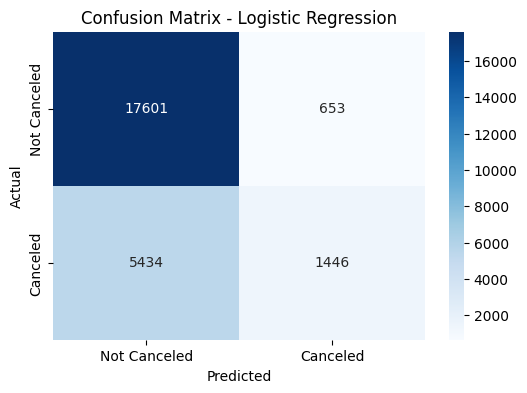

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

Not Canceled       0.76      0.96      0.85     18254
    Canceled       0.69      0.21      0.32      6880

    accuracy                           0.76     25134
   macro avg       0.73      0.59      0.59     25134
weighted avg       0.74      0.76      0.71     25134

Decision Tree - AUC: 0.5961


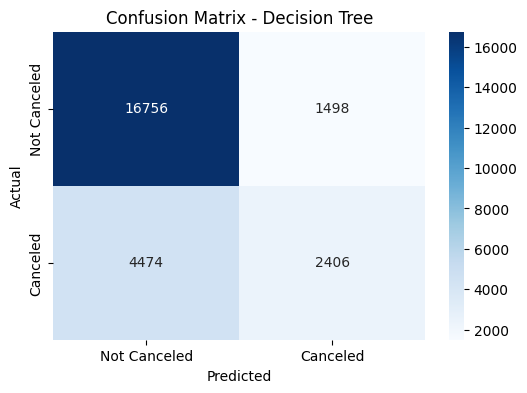

Classification Report for Decision Tree:

              precision    recall  f1-score   support

Not Canceled       0.79      0.92      0.85     18254
    Canceled       0.62      0.35      0.45      6880

    accuracy                           0.76     25134
   macro avg       0.70      0.63      0.65     25134
weighted avg       0.74      0.76      0.74     25134

Random Forest - AUC: 0.7575


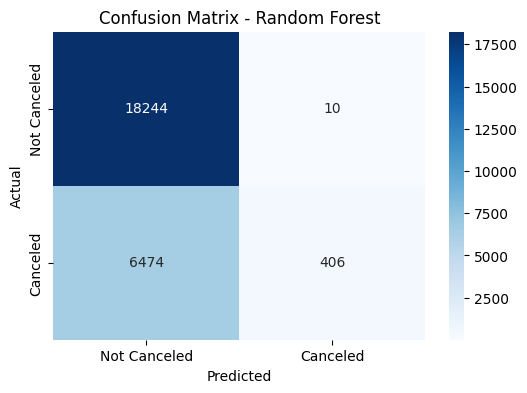

Classification Report for Random Forest:

              precision    recall  f1-score   support

Not Canceled       0.74      1.00      0.85     18254
    Canceled       0.98      0.06      0.11      6880

    accuracy                           0.74     25134
   macro avg       0.86      0.53      0.48     25134
weighted avg       0.80      0.74      0.65     25134

Gradient-Boosted Trees - AUC: 0.7815


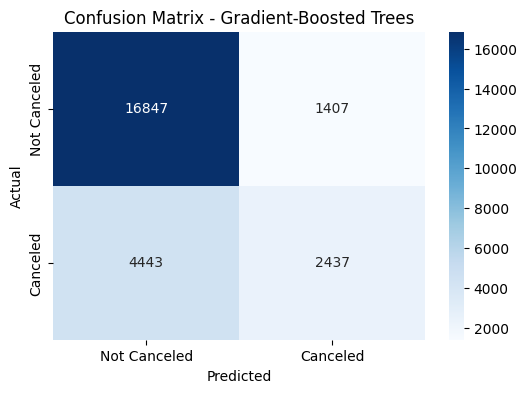

Classification Report for Gradient-Boosted Trees:

              precision    recall  f1-score   support

Not Canceled       0.79      0.92      0.85     18254
    Canceled       0.63      0.35      0.45      6880

    accuracy                           0.77     25134
   macro avg       0.71      0.64      0.65     25134
weighted avg       0.75      0.77      0.74     25134

Naive Bayes - AUC: 0.4581


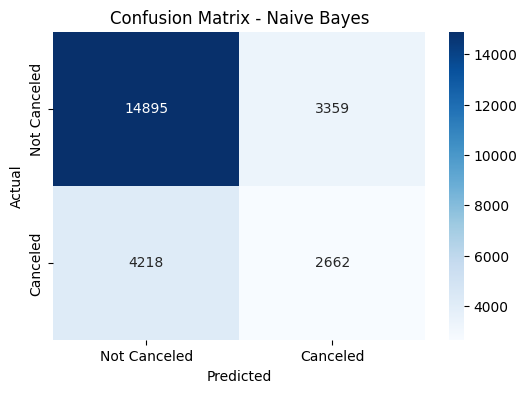

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

Not Canceled       0.78      0.82      0.80     18254
    Canceled       0.44      0.39      0.41      6880

    accuracy                           0.70     25134
   macro avg       0.61      0.60      0.60     25134
weighted avg       0.69      0.70      0.69     25134

SVM - AUC: 0.7483


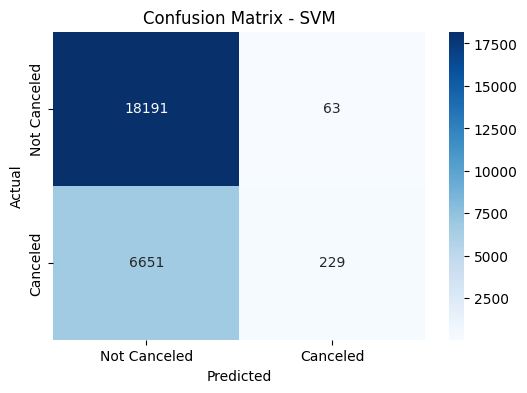

Classification Report for SVM:

              precision    recall  f1-score   support

Not Canceled       0.73      1.00      0.84     18254
    Canceled       0.78      0.03      0.06      6880

    accuracy                           0.73     25134
   macro avg       0.76      0.51      0.45     25134
weighted avg       0.75      0.73      0.63     25134



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

sc.setJobGroup("Task24", "AUC: Confusion Matrix")

# Initialize evaluator for AUC score
evaluator = BinaryClassificationEvaluator(labelCol="is_canceled", metricName="areaUnderROC")

# List of models and their corresponding predictions
models_predictions = {
    "Logistic Regression": log_reg_predictions,
    "Decision Tree": dt_predictions,
    "Random Forest": rf_predictions,
    "Gradient-Boosted Trees": gbt_predictions,
    "Naive Bayes": nb_predictions,
    "SVM": svm_predictions
}

# Evaluate models based on AUC and plot confusion matrix and classification report
for model_name, predictions in models_predictions.items():
    # Evaluate AUC score
    auc = evaluator.evaluate(predictions)
    print(f"{model_name} - AUC: {auc:.4f}")

    # Confusion matrix and classification report
    # Collect actual and predicted values
    y_true = predictions.select("is_canceled").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Canceled", "Canceled"], yticklabels=["Not Canceled", "Canceled"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=["Not Canceled", "Canceled"]))


In [ ]:
import matplotlib.pyplot as plt

sc.setJobGroup("Task25", "Performance Comaprison of the Models")

# Collect results
model_names = list(models_predictions.keys())
auc_scores = [evaluator.evaluate(predictions) for predictions in models_predictions.values()]

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, auc_scores, color='skyblue')
plt.title("Model Comparison: AUC Scores", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("AUC Score", fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.tight_layout()
plt.show()


 Enabling Spark DAG Visualization

In [ ]:
# spark.stop()
# sc.stop()